In [1]:
--------------------------------------------------------------------------------
-- Loading dataset to ram and sorting triplets
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

require 'image'
require 'sys'
require 'xlua'

-- set to 1 if using GPU
cuda = 1
if cuda == 1 then
    require 'cunn'
    require 'cutorch'
end

torch.setdefaulttensortype('torch.FloatTensor')

local dataset = {}
local imageSide = 224


-- Loading the dataset to RAM --------------------------------------------------
if paths.filep('dataset.t7') then
   io.write('Loading whole data set. Please wait...'); io.flush()
   dataset = torch.load('dataset.t7')
   print(' Done.')
else
   -- This script uses pubfig83.v1.tgz from http://vision.seas.harvard.edu/pubfig83/
   -- split in train and test folders
   -- each containing identities folders with images inside.
   -- Format:
   -- datasetRoot/{train,test}/<celebrityName>
   local datasetPaths = {}
   datasetPaths.base = 'pubfig83'

   for _, t in ipairs {'train', 'test'} do
      print('Building ' .. t .. 'ing data set')

      datasetPaths[t] = datasetPaths.base .. '/' .. t .. '/'
      local identities = sys.ls(datasetPaths[t]):split('\n')
        print(identities)
      local dataSize = tonumber(sys.execute('find ' .. datasetPaths[t] .. ' -iname "*.jpg"| wc -l'))
        print(dataSize)
      dataset[t] = {
         data = torch.Tensor(dataSize, 3, imageSide, imageSide),
         label = torch.Tensor(dataSize),
         index = torch.Tensor(#identities, 2),
      }

        
      local count = 0
      for id, idName in ipairs(identities) do
         dataset[t].index[id][1] = count + 1
         for _, img in ipairs(sys.ls(datasetPaths[t] .. idName):split('\n')) do
            count = count + 1
            xlua.progress(count, dataSize)
            -- print(count, paths.concat(datasetPaths[t], idName, img))
            local original = image.load(paths.concat(datasetPaths[t], idName, img))
            local h = original:size(2)
            local w = original:size(3)
            local m = math.min(h, w)
            local y = math.floor((h - m) / 2)
            local x = math.floor((w - m) / 2)
            dataset[t].data[count] = image.scale(
               original[{ {}, {y + 1, y + m}, {x + 1, x + m} }],
               imageSide, imageSide
            )
            dataset[t].label[count] = id
         end
         dataset[t].index[id][2] = count
         collectgarbage()
      end
   end

   io.write('Saving whole data set to disk...'); io.flush()
   torch.save('dataset.t7', dataset)
   print(' Done.')
end


-- Private functions -----------------------------------------------------------
-- Training shuffle
local shuffle

-- New index table for t: train/test
local shuffleShuffle = function(t)
   shuffle = torch.randperm(dataset[t].data:size(1))
end


-- Get nb of (train and test) batches gives the batch size
local nbOfBatches = {}
local batchSize, pImgs
local getNbOfBatches = function(bS)
   batchSize = bS
   for _, t in ipairs {'train', 'test'} do
      nbOfBatches[t] = math.floor(dataset[t].data:size(1) / batchSize)
   end
   pImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   return nbOfBatches
end


-- Initialise the (train and test) embeddings
local embSize
local initEmbeddings = function(eS)
   embSize = eS
   for _, t in ipairs {'train', 'test'} do
      dataset[t].emb = torch.randn(dataset[t].data:size(1), embSize)
      dataset[t].emb = dataset[t].emb:cdiv(dataset[t].emb:norm(2, 2):repeatTensor(1, embSize))
        print(dataset[t])
   end
   print('Training and testing embeddings initialised with size ' .. embSize)
end


-- Get batch number nb for the t (train/test) dataset
-- <mode> by default is 'hard-neg' but can be set to 'soft-neg'
local pEmb
local getBatch = function(nb, t, mode, epoch)

   -- Main varialbles
   local aImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local nImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local emb = torch.Tensor(batchSize, embSize)

   -- Auxiliary variables
   local labels = torch.Tensor(batchSize)
   local offset = batchSize * (nb - 1)

   -- Populating anchor and positive images batches
   for i = 1, batchSize do
      local loc = shuffle[i + offset] -- original location in data set
      aImgs[i]  = dataset[t].data [loc]
      emb[i]    = dataset[t].emb  [loc]
      labels[i] = dataset[t].label[loc]
      if mode ~= 'soft-neg2' then
         pImgs[i]  = dataset[t].data [math.random(
            dataset[t].index[labels[i]][1],
            dataset[t].index[labels[i]][2]
         )]
      end
   end

   -- Populating negative images batche
   local mode = mode or 'hard-neg'
   if mode == 'hard-neg' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms[labels:eq(labels[i])] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   elseif mode == 'soft-neg1' then
      -- do nothing
   elseif mode == 'soft-neg2' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms = norms - torch.Tensor(batchSize):fill((emb[i]-pEmb[i]):norm())
         norms[labels:eq(labels[i])] = norms:max()
         norms[norms:lt(0)] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   else error('Negative populating <mode> not recognised!')
   end

   return {aImgs, pImgs, nImgs}

end


-- Moves the batch to the GPU's RAM
local toCuda = function(batch)
   require 'cutorch'
   for i in ipairs(batch) do batch[i] = batch[i]:cuda() end
end


-- Saves the embeddings emb for the nb batch of t (train/test) data set
local saveEmb = function(emb, nb, t, posEmb)
   local offset = batchSize * (nb - 1)
   for i = 1, batchSize do
      dataset[t].emb[shuffle[i + offset]] = emb[i]:float()
   end
   if posEmb then pEmb = posEmb:float() end
end

local getDataset = function()
    
end

-- Public functions ------------------------------------------------------------
return {
   select         = shuffleShuffle,
   getNbOfBatches = getNbOfBatches,
   initEmbeddings = initEmbeddings,
   getBatch       = getBatch,
   toCuda         = toCuda,
   saveEmb        = saveEmb,
}

Loading whole data set. Please wait...

 Done.	


In [2]:
torch.manualSeed(0)
math.randomseed(0)

data = require 'data'

-- Shuffling training data
data.select('train') -- or 'test'

-- Initialise embeddings
embDim = 5
data.initEmbeddings(embDim)

-- Get train and test number of batches
batchDim = 10
trainBatches = data.getNbOfBatches(batchDim).train
print('trainBatches: ', trainBatches)

-- Get training batch nb 1
batch = data.getBatch(1, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)

-- Send batch to cuda
--collectgarbage()
--data.toCuda(batch)
--print('Batch sent to GPU memory')

-- Saving embeddings
data.saveEmb(torch.randn(batchDim, embDim), 1, 'train')
print('Embedding saved for fast training')



Loading whole data set. Please wait...

 Done.	


Training and testing embeddings initialised with size 5	
trainBatches: 	138	


batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x224x224
  2 : FloatTensor - size: 10x3x224x224
  3 : FloatTensor - size: 10x3x224x224
}
Embedding saved for fast training	


In [4]:
function printTriplets(batch)
    for i = 1, 10 do
            itorch.image({image.scale(batch[1][i], 48, 48), image.scale(batch[2][i], 48, 48), 
                image.scale(batch[3][i], 48, 48)})
    end
end

batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x224x224
  2 : FloatTensor - size: 10x3x224x224
  3 : FloatTensor - size: 10x3x224x224
}


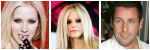

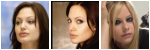

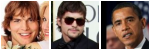

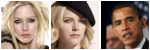

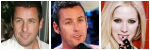

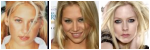

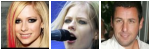

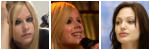

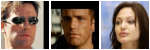

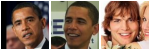

In [5]:

batch = data.getBatch(138, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)
printTriplets(batch)

In [6]:
require 'nn'
alexnet = torch.load('alexnetowtbn_epoch55_cpu.t7')

In [3]:
function createModel(alexnet)
--     local alexnet = createModelAlex()
    --convNet = createModelAlex()
    local alexnet = alexnet:clone()
    alexnet:evaluate()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()

    convNet = alexnet
    convNet:get(2):add(nn.View(4096))
    convNet:get(2):add(nn.Linear(4096, 128))
    convNet:get(2):add(nn.Normalize(2))
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel
end

function createModelTrip()
    embeddingSize = 3
    convNet = nn.Sequential()
    convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.View(8*2*2))
    convNet:add(nn.Linear(8*2*2, embeddingSize))
    convNet:add(nn.BatchNormalization(embeddingSize))
    
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel:cuda()
end


function computeSimilarity(x, y)
--     -- use L2 norm distance
--     diff = x - y
--     return diff:norm(2,1):pow(2)
--     local dist_sum = 0
--     for i = 1, 128 do
--         dist_sum += x[i] 
    return torch.dist(x, y)
end

In [4]:
imgDim = 224

local conv = nn.SpatialConvolutionMM
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

function createModelVGG()
   local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   -- net:add(nn.Reshape(25088))

   net:add(nn.View(25088))
   net:add(nn.Linear(25088, 4096))
   net:add(relu(true))

   net:add(nn.Linear(4096, 128))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)

    return parallel
end

function createModelAlex()
    local net = nn.Sequential()
    local fb1 = nn.Sequential()
    fb1:add(nn.SpatialConvolution(3,64,11,11,4,4,2,2))       -- 224 -> 55
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 55 ->  27
    fb1:add(nn.SpatialConvolution(64,192,5,5,1,1,2,2))       --  27 -> 27
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   --  27 ->  13
    fb1:add(nn.SpatialConvolution(192,384,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(384,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(256,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 13 -> 6

    local classifier = nn.Sequential()
    classifier:add(nn.View(256*6*6))
    classifier:add(nn.Dropout(0.5))
    classifier:add(nn.Linear(256*6*6, 4096))
    classifier:add(nn.Threshold(0, 1e-6))
    classifier:add(nn.Dropout(0.5))
--     classifier:add(nn.View(4096))
    classifier:add(nn.Linear(4096, 128))
    classifier:add(nn.Normalize(2))
    
    net:add(fb1)
    net:add(classifier)
    return net
end

In [5]:
require 'nn'

--Load the AlexNet model
meanStd = torch.load('alexnetowtbn_meanStd.t7')

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

In [6]:
require 'nn'
require 'TripletEmbedding'

local criterion = nn.TripletEmbeddingCriterion()
if cuda == 1 then
    criterion = criterion:cuda()
end

function trainModel(model, opt)
    if cuda == 1 then
        print("loading model onto GPU")
        model = model:cuda()
    end
    
    -- Get all the parameters (and gradients) of the model in a single vector.
    print("getting params")
    -- local params, gradParams = model:getParameters()
    local singleNet = model.modules[1]
    local opt = opt or {}
    local batchSize = opt.batchSize or 10  -- The bigger the batch size the most accurate the gradients.
    local numEpochs = opt.numEpochs or 3
    print("getting batches")
    local trainBatches = data.getNbOfBatches(batchSize).train
    print('trainBatches: ', trainBatches)
    local numEpochs = trainBatches
    -- Go over the training data this number of times.
    local inputs = data.getBatch(1, 'train')
     for epoch = 1, 100 do
        local sum_loss = 0
        local correct = 0
--         local inputs = data.getBatch(1, 'train')

        -- Run over the training set samples.
        -- set internal var Train=True so that layers like Dropout behave correctly. Also see :evaluate()
        
--         model:training()
        
        -- 2. Perform the forward pass (prediction mode).
        --:view(1, 3, 224, 224)
        -- Ancore training samples/images
        local imageDim = 20
        local batch = 10
        aImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        pImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        -- Negative training samples/images
        nImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
--         print(nImgs)
        
        
        wrapperTotal = torch.Tensor(3, 10, 3, imageDim, imageDim)
        
        for apn = 1, 3 do
            for batchN = 1, batchSize do
                wrapper = torch.Tensor(1, 3, imageDim, imageDim)
                wrapper[1] = image.scale(inputs[apn][batchN], imageDim, imageDim)
                wrapperTotal[apn][batchSize] = wrapper
            end
        end
--         wrapperTotal = {inputs[1], inputs[2], inputs[3]}
--         wrapperTotal = inputs
        
--         print(image.scale(inputs[1], imageDim, imageDim))
--         print('haha')
        if cuda == 1 then
            wrapperTotal = wrapperTotal:cuda()
        end
--         print(inputs)
--         print(inputs:size())
--         print({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
--         local predictions = model:forward({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
        print({aImgs, pImgs, nImgs})
        local predictions = model:forward({aImgs, pImgs, nImgs})
--         print('haha1')
        print(predictions)
        --print("passed")
        -- 3. Evaluate results.
        --for i = 1, predictions:size(1) do
        --    local _, predicted_label = predictions[i]:max(1)
        --    if predicted_label[1] == labels[i] then correct = correct + 1 end
        --end
        local sum_loss = sum_loss + criterion:forward(predictions)
--         print("passed stage 2")
        -- TODO: need to figure out how to change this to accomandate the BCECriterion
        -- 4. Perform the backward pass (compute derivatives).
        -- This zeroes-out all the parameters inside the model pointed by variable params.
        
--          print("passed stage 3")
        -- This internally computes the gradients with respect to the parameters pointed by gradParams.
        local gradPredictions = criterion:backward(predictions)
        model:zeroGradParameters()
--          print("passed stage 4")
        --{wrapper, wrapper2, wrapper3}
        model:backward({aImgs, pImgs, nImgs}, gradPredictions)
        model:updateParameters(0.01)
--          print("passed stage 5")
         -- 5. Perform the SGD update.
        if epoch % 100 == 0 then
            model:updateParameters(0.01)
        end
        
        if epoch % 10 == 0 then  -- Print this every 10 epochs.
            print(('train epoch=%d, avg-loss=%.6f')
                :format(epoch, sum_loss / epoch))
        end

        -- Run over the validation set for evaluation.
        print(epoch)
        itorch.image({image.scale(inputs[1][1], 48, 48), image.scale(inputs[2][1], 48, 48), 
                image.scale(inputs[3][1], 48, 48)})
        
        if epoch == 1 then
            print(predictions[1][1])
        end
        
        local ap = computeSimilarity(predictions[1][1], predictions[2][1])
        local an = computeSimilarity(predictions[1][1], predictions[3][1])
        print(('\na-->p %.4f'):format(ap))
        print(('\na-->n %.4f'):format(an))
        --print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
    end
end

In [7]:
model = createModelTrip()


loading model onto GPU	
getting params	
getting batches	
trainBatches: 	138	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


1	


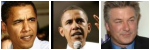

 0.0344
-0.4377
 0.0279
[torch.CudaTensor of size 3]


a-->p 1.2359	

a-->n 1.3530	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


2	


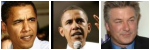


a-->p 0.8259	

a-->n 0.7371	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


3	


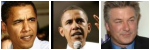


a-->p 0.8957	

a-->n 1.5047	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


4	


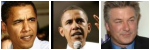


a-->p 1.2538	

a-->n 0.9154	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


5	


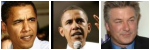


a-->p 1.8568	

a-->n 1.5023	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


6	


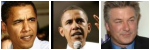


a-->p 0.4028	

a-->n 1.3015	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


7	


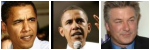


a-->p 0.4482	

a-->n 1.5703	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


8	


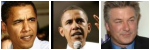


a-->p 0.4844	

a-->n 0.9824	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


9	


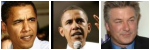


a-->p 0.4197	

a-->n 0.8346	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=10, avg-loss=0.083313	
10	


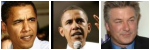


a-->p 0.5766	

a-->n 1.9074	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


11	


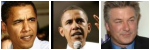


a-->p 0.7554	

a-->n 0.9497	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


12	


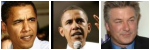


a-->p 1.2992	

a-->n 0.6497	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


13	


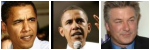


a-->p 0.5759	

a-->n 1.2114	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


14	


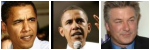


a-->p 0.4577	

a-->n 0.5128	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


15	


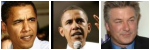


a-->p 0.9094	

a-->n 0.2544	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


16	


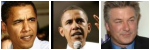


a-->p 0.3754	

a-->n 1.1787	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


17	


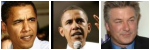


a-->p 0.5826	

a-->n 0.7560	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


18	


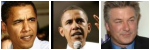


a-->p 0.4973	

a-->n 0.4269	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


19	


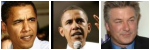


a-->p 0.3028	

a-->n 0.5675	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=20, avg-loss=0.014829	
20	


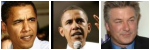


a-->p 1.2909	

a-->n 0.8812	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


21	


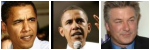


a-->p 0.2247	

a-->n 0.6766	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


22	


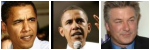


a-->p 0.6416	

a-->n 0.3734	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


23	


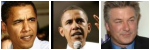


a-->p 0.4947	

a-->n 0.2761	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


24	


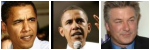


a-->p 0.9505	

a-->n 0.6834	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


25	


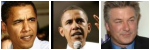


a-->p 0.3969	

a-->n 0.2814	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


26	


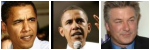


a-->p 0.2617	

a-->n 0.3870	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


27	


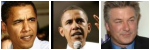


a-->p 0.6221	

a-->n 0.3027	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


28	


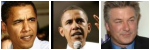


a-->p 0.6377	

a-->n 0.2865	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


29	


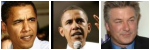


a-->p 0.2285	

a-->n 0.3272	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=30, avg-loss=0.006566	
30	


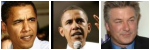


a-->p 0.5361	

a-->n 0.2387	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


31	


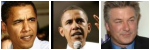


a-->p 0.3726	

a-->n 0.2635	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


32	


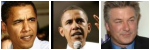


a-->p 0.4240	

a-->n 0.3907	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


33	


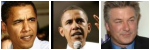


a-->p 0.3753	

a-->n 0.5538	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


34	


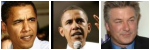


a-->p 0.4062	

a-->n 0.3245	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


35	


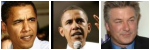


a-->p 0.6734	

a-->n 0.4829	


{
  1 : CudaTensor - size: 10x3x20x20


  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


36	


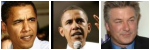


a-->p 0.4249	

a-->n 0.3834	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


37	


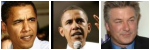


a-->p 0.2052	

a-->n 0.2571	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


38	


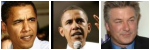


a-->p 0.3968	

a-->n 0.5014	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


39	


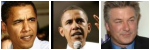


a-->p 0.3671	

a-->n 0.2907	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=40, avg-loss=0.004171	
40	


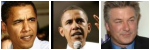


a-->p 0.2365	

a-->n 0.5334	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


41	


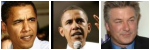


a-->p 0.1124	

a-->n 0.4674	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


42	


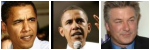


a-->p 0.3484	

a-->n 0.2086	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


43	


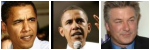


a-->p 0.2350	

a-->n 0.3235	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


44	


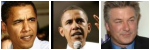


a-->p 0.2128	

a-->n 0.3502	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


45	


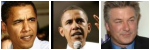


a-->p 0.2039	

a-->n 0.1363	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


46	


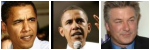


a-->p 0.3196	

a-->n 0.4217	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


47	


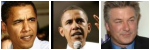


a-->p 0.4966	

a-->n 0.4949	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


48	


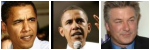


a-->p 0.5431	

a-->n 0.4842	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{


  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


49	


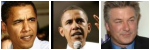


a-->p 0.3245	

a-->n 0.2205	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=50, avg-loss=0.004527	
50	


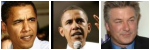


a-->p 0.3325	

a-->n 0.2983	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


51	


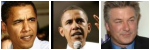


a-->p 0.2126	

a-->n 0.3752	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


52	


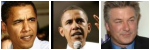


a-->p 0.4079	

a-->n 0.4181	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


53	


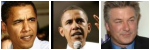


a-->p 0.1980	

a-->n 0.1461	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{


  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


54	


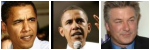


a-->p 0.2638	

a-->n 0.1628	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


55	


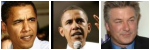


a-->p 0.1500	

a-->n 0.2640	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


56	


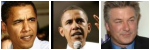


a-->p 0.1199	

a-->n 0.2354	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


57	


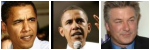


a-->p 0.4550	

a-->n 0.2376	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


58	


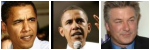


a-->p 0.2636	

a-->n 0.1701	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


59	


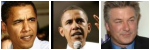


a-->p 0.1636	

a-->n 0.3017	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=60, avg-loss=0.003785	
60	


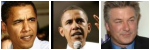


a-->p 0.3600	

a-->n 0.2904	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


61	


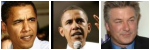


a-->p 0.1964	

a-->n 0.1879	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


62	


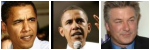


a-->p 0.4857	

a-->n 0.1988	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


63	


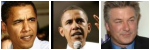


a-->p 0.1740	

a-->n 0.3344	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3


}


64	


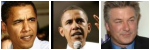


a-->p 0.2247	

a-->n 0.7140	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


65	


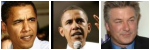


a-->p 0.1982	

a-->n 0.1960	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


66	


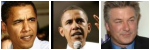


a-->p 0.3709	

a-->n 0.5049	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


67	


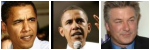


a-->p 0.0899	

a-->n 0.2754	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


68	


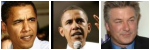


a-->p 0.6111	

a-->n 0.6010	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


69	


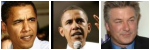


a-->p 0.3639	

a-->n 0.2659	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=70, avg-loss=0.002768	
70	


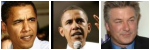


a-->p 0.2755	

a-->n 0.1986	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


71	


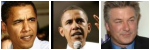


a-->p 0.4113	

a-->n 0.3247	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


72	


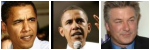


a-->p 0.5908	

a-->n 0.1431	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


73	


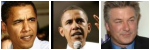


a-->p 0.2381	

a-->n 0.1425	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


74	


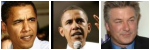


a-->p 0.1148	

a-->n 0.2387	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


75	


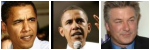


a-->p 0.2192	

a-->n 0.4092	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


76	


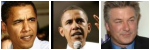


a-->p 0.2375	

a-->n 0.0710	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


77	


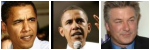


a-->p 0.1455	

a-->n 0.1324	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}
{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


78	


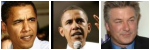


a-->p 0.1329	

a-->n 0.1224	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


79	


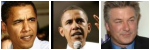


a-->p 0.0937	

a-->n 0.1143	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=80, avg-loss=0.002661	
80	


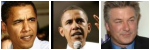


a-->p 0.3419	

a-->n 0.1740	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


81	


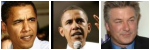


a-->p 0.2364	

a-->n 0.3338	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


82	


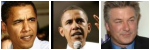


a-->p 0.1665	

a-->n 0.1658	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


83	


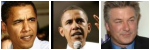


a-->p 0.4304	

a-->n 0.1845	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


84	


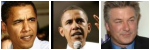


a-->p 0.2425	

a-->n 0.1150	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


85	


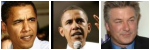


a-->p 0.1841	

a-->n 0.2231	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


86	


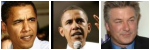


a-->p 0.3917	

a-->n 0.2390	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


87	


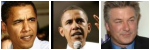


a-->p 0.1703	

a-->n 0.1085	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


88	


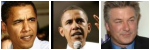


a-->p 0.3131	

a-->n 0.2912	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


89	


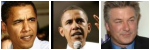


a-->p 0.0970	

a-->n 0.0972	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=90, avg-loss=0.001979	
90	


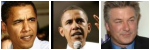


a-->p 0.2151	

a-->n 0.0961	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


91	


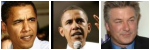


a-->p 0.2005	

a-->n 0.1166	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


92	


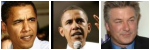


a-->p 0.1625	

a-->n 0.0499	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


93	


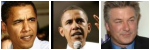


a-->p 0.2456	

a-->n 0.1415	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


94	


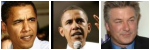


a-->p 0.0612	

a-->n 0.0756	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


95	


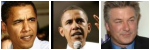


a-->p 0.3618	

a-->n 0.1314	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


96	


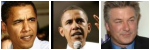


a-->p 0.1095	

a-->n 0.1269	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


97	


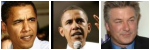


a-->p 0.1709	

a-->n 0.0718	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


98	


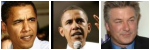


a-->p 0.1694	

a-->n 0.1829	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


99	


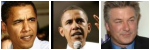


a-->p 0.3290	

a-->n 0.1832	


{
  1 : CudaTensor - size: 10x3x20x20
  2 : CudaTensor - size: 10x3x20x20
  3 : CudaTensor - size: 10x3x20x20
}


{
  1 : CudaTensor - size: 10x3
  2 : CudaTensor - size: 10x3
  3 : CudaTensor - size: 10x3
}


train epoch=100, avg-loss=0.001857	
100	


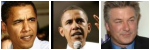


a-->p 0.1900	

a-->n 0.3386	



In [12]:
trainModel(model:clone(), {})

In [17]:
--------------------------------------------------------------------------------
-- Fresh embedding training example
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

-- package.path = "../?.lua;" .. package.path

require 'nn'
require 'TripletEmbedding'
colour = require 'trepl.colorize'
local b = colour.blue

torch.manualSeed(0)


batchSize = 5
embeddingSize = 3
imgSize = 20
local trainBatches = data.getNbOfBatches(batchSize).train
local inputs = data.getBatch(1, 'train')

local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
    torch.Tensor(batchSize, 3, imgSize, imgSize),
    torch.Tensor(batchSize, 3, imgSize, imgSize)}

for apn = 1, 3 do
    for imgN = 1, batchSize do
        resize_inputs[apn][imgN] = image.scale(inputs[apn][imgN], imgSize, imgSize)
    end
end
print('pass')
aImgs = resize_inputs[1]
-- Positive training samples/images
pImgs = resize_inputs[2]
-- Negative training samples/images
nImgs = resize_inputs[3]



-- Network definition
convNet = nn.Sequential()
convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
convNet:add(nn.ReLU())
convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
convNet:add(nn.ReLU())
convNet:add(nn.View(8*2*2))
convNet:add(nn.Linear(8*2*2, embeddingSize))
convNet:add(nn.BatchNormalization(embeddingSize))

convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')

-- Parallel container
parallel = nn.ParallelTable()
parallel:add(convNet)
parallel:add(convNetPos)
parallel:add(convNetNeg)
parallel = parallel:cuda()

-- local conv = nn.SpatialConvolutionMM
-- local relu = nn.ReLU
-- local mp = nn.SpatialMaxPooling

-- local net = nn.Sequential()

--    net:add(conv(3, 64, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(64, 64, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(mp(2,2, 2,2))
--    net:add(conv(64, 128, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(128, 128, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(mp(2,2, 2,2))
--    net:add(conv(128, 256, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(256, 256, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(256, 256, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(mp(2,2, 2,2))
--    net:add(conv(256, 512, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(512, 512, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(512, 512, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(mp(2,2, 2,2))
--    net:add(conv(512, 512, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(512, 512, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(conv(512, 512, 3,3, 1,1, 1,1))
--    net:add(relu(true))
--    net:add(mp(2,2, 2,2))

--    -- Validate shape with:
--    -- net:add(nn.Reshape(25088))

--    net:add(nn.View(25088))
--    net:add(nn.Linear(25088, 4096))
--    net:add(relu(true))

--    net:add(nn.Linear(4096, 128))
--    net:add(nn.Normalize(2))
    
--     convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
--     convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
--     -- Parallel container
--     parallel = nn.ParallelTable()
--     parallel:add(net)
--     parallel:add(convNetPos)
--     parallel:add(convNetNeg)
--     parallel = parallel:cuda()
-- print(b('Fresh-embeddings-computation network:')); print(parallel)

-- Cost function
loss = nn.TripletEmbeddingCriterion()
loss = loss:cuda()

for i = 1, 100 do
   print(colour.green('Epoch ' .. i))
    local inputs = {aImgs, pImgs, nImgs}
   predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
    print(inputs)
   err = loss:forward(predict)
   errGrad = loss:backward(predict)
   parallel:zeroGradParameters()
   parallel:backward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()}, errGrad)
   parallel:updateParameters(0.0001)
    local mean_ap = 0
    local mean_an = 0
    for j = 1, batchSize do
        local ap = computeSimilarity(predict[1][j], predict[2][j])
        local an = computeSimilarity(predict[1][j], predict[3][j])
        mean_ap = mean_ap + ap
        mean_an = mean_an + an
    end
    mean_ap = mean_ap / batchSize
    mean_an = mean_an / batchSize
        
    print(('\na-->p %.4f'):format(mean_ap))
    print(('\na-->n %.4f'):format(mean_an))

   print(colour.red('loss: '), err)
--    print(b('gradInput[1]:')); print(errGrad[1])
end

pass	


Epoch 1	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 1.1200	

a-->n 0.6466	
loss: 	1.696167755127	
Epoch 2	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.8238	

a-->n 1.2050	
loss: 	0.82494230270386	
Epoch 3	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.6205	

a-->n 1.3788	
loss: 	0.1724954366684	
Epoch 4	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.6013	

a-->n 1.4321	
loss: 	0.018844822049141	
Epoch 5	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.6241	

a-->n 1.4691	
loss: 	

0.058744943141937	
Epoch 6	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 7	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 8	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 9	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 10	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 11	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 12	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 13	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 14	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 15	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 16	
{


  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 17	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 18	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 19	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 20	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 21	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 22	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20


  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 23	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 24	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 25	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 26	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 27	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 28	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 29	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 30	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 31	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 32	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 33	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 34	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 35	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 36	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 37	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 38	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 39	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 40	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 41	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 42	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 43	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 44	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 45	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 46	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 47	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 48	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 49	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 50	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 51	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 52	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 53	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 54	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 55	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 56	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 57	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 58	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 59	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 60	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 61	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 62	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20


  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 63	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 64	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 65	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 66	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 67	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 68	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 69	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 70	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 71	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 72	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 73	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 74	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 75	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 76	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 77	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 78	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 79	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 80	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 81	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 82	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 83	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 84	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 85	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 86	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 87	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 88	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 89	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 90	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 91	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 92	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 93	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 94	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20


  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 95	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 96	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 97	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 98	
{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 99	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
Epoch 100	


{
  1 : FloatTensor - size: 5x3x20x20
  2 : FloatTensor - size: 5x3x20x20
  3 : FloatTensor - size: 5x3x20x20
}



a-->p 0.5324	

a-->n 1.4049	
loss: 	0	
